In [1]:
# !conda update -n base conda
# !conda install -c conda-forge imbalanced-learn


In [2]:
import pandas as pd
from zipfile import ZipFile
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
zip_file = ZipFile('../../data/raw/forStudents.pkl.zip')
df = pd.read_pickle(zip_file.open('forStudents.pkl'))
df

,acquisition_type,snapshot_type,channel,evaluation_dt,vintage,is_app_approved,vantage3_score,bad,bad_v2,bad_balance,...,rtr5930,rtr7110,rtr7140,rtr7160,rtr7216,rtr7620,rtr8120,rtr8220,rtr8320,rowNumber
0,ORGANIC,FLOW_MODULARITY,OTHER,2021-08-04,202108,1,698.0,0.0,0.0,0.0,...,2.0,4.0,4.0,9.0,5.0,100.0,5.0,5.0,5.0,59486
1,ORGANIC,FLOW_MODULARITY,OTHER,2021-03-01,202103,1,731.0,0.0,0.0,0.0,...,30.0,2.0,2.0,130.0,12.0,100.0,4.0,4.0,4.0,2357
2,ORGANIC,FLOW_MODULARITY,OTHER,2021-02-26,202102,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90398
3,ORGANIC,FLOW_MODULARITY,OTHER,2021-06-04,202106,1,715.0,0.0,0.0,0.0,...,249.0,18.0,18.0,56.0,7.0,100.0,5.0,151.0,45.0,104654
4,ORGANIC,FLOW_MODULARITY,OTHER,2021-07-14,202107,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48707,ORGANIC,FLOW_MODULARITY,OTHER,2021-05-01,202105,1,732.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,131881
48708,ORGANIC,FLOW_MODULARITY,OTHER,2020-11-29,202011,1,705.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,47197
48709,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-25,202104,1,722.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,NaN,2.0,167.0,86.0,29739
48710,ORGANIC,FLOW_MODULARITY,OTHER,2021-04-10,202104,1,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89207


In [4]:
# Clean and imputation

df_clean = df[df['all0000'].notna()]
df_clean = df_clean[df_clean['bad'] != -1.0]
df_clean = df_clean[df_clean['is_app_approved'] == 1]
df_clean.drop(columns=['bad_v2','evaluation_dt','vintage'], inplace=True)
described = df_clean["annual_income"].describe()
quartiles = list(described.iloc[4:7])

In [5]:
def assign_quartile(row):
    income = row["annual_income"]
    if income < quartiles[0]:
        return 0
    elif ((quartiles[0] < income) & (quartiles[1] >= income)):
        return 1
    elif ((quartiles[1] < income) & (quartiles[2] >= income)):
        return 2
    else:
        return 3

In [6]:
df_clean.apply(assign_quartile, axis=1).value_counts().sort_index()

0    10625
1    10546
2    10709
3    10667
dtype: int64

In [7]:
df_clean['income_quartile'] = df_clean.apply(assign_quartile, axis=1)

In [8]:
dfs = []
for i in range(4):
    quartile = df_clean.loc[df_clean["income_quartile"] == i]
    dfs.append(quartile.fillna(quartile.mean()))
    
df_clean = pd.concat(dfs)

temp = df_clean.isna().sum().to_frame()
temp[temp[0] != 0]

df_clean.drop(columns=['all9230', 'all9240', 'all9249', 'all9280'], inplace=True)
df_clean = df_clean.fillna(df_clean.mean())

/tmp/ipykernel_174/448997779.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfs.append(quartile.fillna(quartile.mean()))
/tmp/ipykernel_174/448997779.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_clean = df_clean.fillna(df_clean.mean())


In [9]:
# Categorical

def process_categorical_data(dataset):
    """ One hot encodes all of the categorial columns of the dataset.  Removes the original columns """
    # select categorical data
    categorical_data = dataset.select_dtypes('object')
    
    enc = OneHotEncoder(handle_unknown='ignore')
    
    ohe_data = enc.fit_transform(categorical_data).toarray()
    column_names = enc.get_feature_names(categorical_data.columns)
    
    add = dataset.select_dtypes(exclude='object')
    added = pd.DataFrame(ohe_data,columns=column_names).astype(int)
    
    add.reset_index(drop = True, inplace= True)
    added.reset_index(drop = True, inplace= True)
    X = pd.concat([add, 
               added], axis=1)
    print(X.shape)
    return X

df_clean = process_categorical_data(df_clean)
df_clean

(42547, 891)


/home/cepan/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,is_app_approved,vantage3_score,bad,bad_balance,current_balance,net_spend,annual_income,all0000,all0060,all0061,...,state_code_SD,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_VT,state_code_WA,state_code_WI,state_code_WV,state_code_WY
0,1,698.0,0.0,0.0,0.00,5.51,15171,10.0,8.000000,8.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,731.0,0.0,0.0,30.95,30.95,20000,3.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
2,1,701.0,0.0,0.0,0.00,0.00,7000,6.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
3,1,655.0,1.0,870.6,870.60,0.00,18000,3.0,1.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
4,1,665.0,0.0,0.0,784.55,0.00,30000,6.0,4.165954,5.237061,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42542,1,651.0,0.0,0.0,2593.57,243.18,125000,12.0,9.305257,11.139763,...,0,0,0,0,0,0,0,0,0,0
42543,1,635.0,0.0,0.0,971.05,971.05,101000,60.0,21.000000,11.139763,...,0,0,0,0,0,0,0,0,0,0
42544,1,628.0,0.0,0.0,0.00,0.00,145000,53.0,9.305257,11.139763,...,0,0,0,0,0,0,0,0,0,0
42545,1,642.0,0.0,0.0,0.00,0.00,72000,7.0,9.305257,11.139763,...,0,0,0,0,0,0,1,0,0,0


In [10]:
# Imbalance dataset

oversample = SMOTE()
X = df_clean.drop('bad', axis=1)
y = df_clean['bad'].astype(int)
counter = Counter(y)
print(counter)
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

Counter({0: 38854, 1: 3693})
Counter({0: 38854, 1: 38854})


In [11]:
y

0        0
1        0
2        0
3        1
4        0
        ..
77703    1
77704    1
77705    1
77706    1
77707    1
Name: bad, Length: 77708, dtype: int64

In [12]:
# Splitting Dataset
from sklearn.linear_model import LogisticRegression
# X = df_clean.drop('bad', axis=1)
# y = df_clean[['bad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression().fit(X_train,y_train)
y_pred =clf.predict(X_test)


/home/cepan/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[10492,  1216],
       [ 1176, 10429]])

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     11708
           1       0.90      0.90      0.90     11605

    accuracy                           0.90     23313
   macro avg       0.90      0.90      0.90     23313
weighted avg       0.90      0.90      0.90     23313



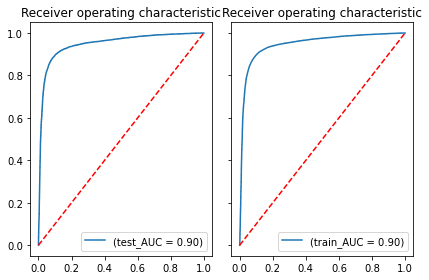

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1, 2, sharey=True)

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
axes[0].plot(fpr, tpr, label='(test_AUC = %0.2f)' % logit_roc_auc)
axes[0].plot([0, 1], [0, 1],'r--')
# axes[0].xlim([0.0, 1.0])
# axes[0].ylim([0.0, 1.05])
# axes[0].xlabel('False Positive Rate')
# axes[0].ylabel('True Positive Rate')
axes[0].title.set_text('Receiver operating characteristic')
axes[0].legend(loc="lower right")
# axes[0].savefig('Log_ROC')
# axes[0].show()

logit_roc_auc = roc_auc_score(y_train, clf.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.figure()
axes[1].plot(fpr, tpr, label='(train_AUC = %0.2f)' % logit_roc_auc)
axes[1].plot([0, 1], [0, 1],'r--')
# axes[1].xlim([0.0, 1.0])
# axes[1].ylim([0.0, 1.05])
# axes[1].xlabel('False Positive Rate')
# axes[1].ylabel('True Positive Rate')
axes[1].title.set_text('Receiver operating characteristic')
axes[1].legend(loc="lower right")
# axes[1].savefig('Log_ROC')
# axes[1].show()
fig.tight_layout()



/home/cepan/.local/lib/python3.9/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


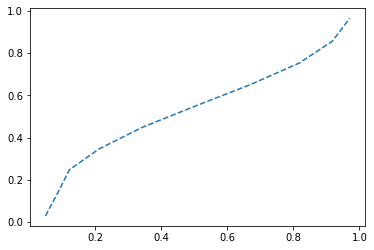

In [16]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, clf.predict_proba(X_test)[:,1], n_bins=10, normalize = True)

plt.plot(prob_true,prob_pred,linestyle='--')
